In [1]:
from imports import *
import pickle

# device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device = torch.device("cuda:0")

In [2]:
classes = {
    "bus": 0,
    "traffic light": 1,
    "traffic sign": 2,
    "person": 3,
    "bike": 4,
    "truck": 5,
    "motor": 6,
    "car": 7,
    "train": 8,
    "rider": 9,
}
class_2_name = dict([(value, key) for key, value in classes.items()])

num_classes = len(classes)

## 1. Load model

In [3]:
def get_model(num_classes):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    #model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes) # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features,num_classes)
    return model.cpu()

In [15]:
model = get_model(num_classes)

In [17]:
checkpoint = torch.load('saved_models/bdd100k_24.pth')
model.load_state_dict(checkpoint['model'])
#optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
#epoch = checkpoint['epoch']
# model.eval()

<All keys matched successfully>

## 2. Show sample plot

In [18]:
def get_preds(idx,img_datalist,threshold):
    im0 = Image.open(img_datalist[idx])
    im0_tensor = torchvision.transforms.ToTensor()(im0)
    pred = model([im0_tensor])
    total_preds = []
    for n,confidence in enumerate(pred[0]['scores']):
        if confidence>threshold:
            pred_update = {}
            pred_update['boxes'] = pred[0]['boxes'][n]
            pred_update['labels'] = pred[0]['labels'][n]
            pred_update['scores'] = pred[0]['scores'][n]
        total_preds.append(pred_update)
    return im0,total_preds

In [19]:
def plot_from_image_preds(img,total_preds):
    fig,ax = plt.subplots(1,figsize=(20,10))
    for i in range(len(total_preds)):
        xy = total_preds[i]['boxes'][0],total_preds[i]['boxes'][1]
        width = total_preds[i]['boxes'][2]-total_preds[i]['boxes'][0]
        height = total_preds[i]['boxes'][3]-total_preds[i]['boxes'][1]
        rect = patches.Rectangle(xy,width,height,linewidth=1,edgecolor='r',facecolor='none')
        ax.text(xy[0],xy[1],class_2_name[total_preds[i]['labels'].item()])
        ax.add_patch(rect)
    ax.imshow(img)

In [20]:
with open("datalists/bdd100k_val_images_path.txt", "rb") as fp:
    val_img_paths = pickle.load(fp)

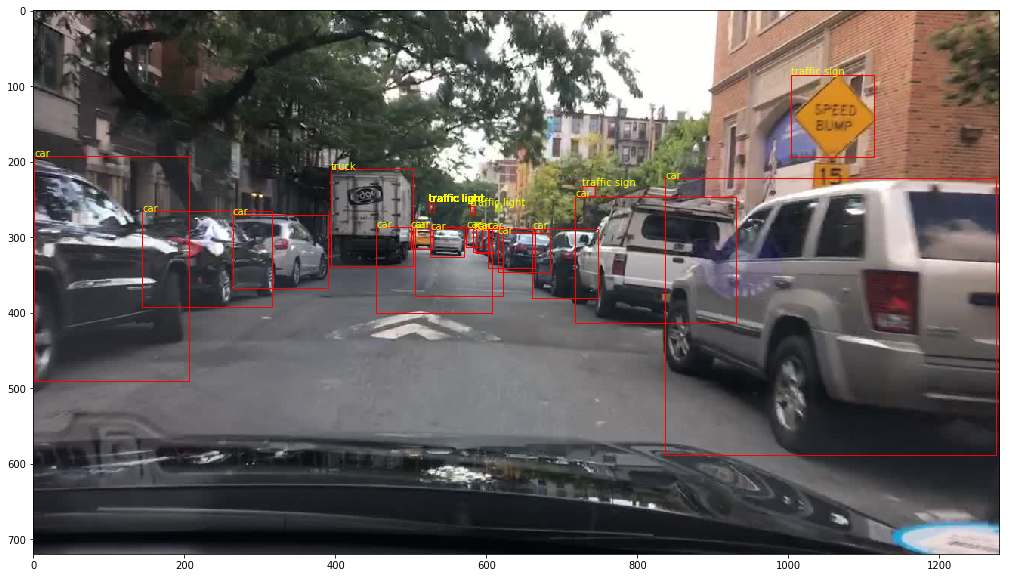

In [21]:
im, total_preds = get_preds(12,val_img_paths,0.6)
plot_from_image_preds(im,total_preds)